$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [6]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=2

global T
global target
T=10
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global num_action
num_action=11

global obs_para
obs_para=6

global coeff
coeff=[]
for i in range(N+1):
    coeff.append(1)
print(coeff)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [8]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(10-np.sqrt((obs[0]-target[0])**2+(obs[1]-target[1])**2)-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [9]:
global lr
lr=0.01
global eps
eps=0.05
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/2],[-1,np.pi/2],[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4],[1,-np.pi/2],[-1,-np.pi/2],[0,0]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(num_action)
    else:
        result=[]
        for i in range(num_action):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(num_action):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(num_action)]
history_r=[0 for i in range(num_action)]
history_su_next=[0 for i in range(num_action)]
flags=[True for i in range(num_action)]

history_rt=[[[] for i in range(num_action)] for j in range(N+1)]
history_sut=[[[] for i in range(num_action)] for j in range(N+1)]
flags_t=[[True for i in range(num_action)] for j in range(N+1)]

# Simulation


In [10]:
num_iter=120

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(num_action)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    random_pos=np.random.rand(3)-np.array([0.5,0.5,0.5])
    random_pos[0]=random_pos[0]/5
    random_pos[1]=random_pos[1]/5
    random_pos[2]=random_pos[2]*np.pi
    
    
    position=np.array([[-2+random_pos[0],-2+random_pos[1],0+random_pos[2]] for _ in range(num_system)])
    
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(num_action)]
    
    '''
    coeff=[]
    for i in range(N):
        coeff.append((np.random.random()-0.5)/100+0.8**(N-i))
    coeff.append(1)
    #print(coeff)
    '''
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(num_action):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-8).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(num_action):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-8).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(num_action):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-8).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|▋                                                                                 | 1/120 [00:00<01:24,  1.41it/s]

observation = [-1.38881345 -1.51524913  1.30135296  0.00186546  0.0021008   0.00521238]


  2%|█▎                                                                                | 2/120 [00:01<01:22,  1.43it/s]

observation = [-2.41254556  0.19438463 -0.76742484  0.01315768  0.02070158  0.00604513]


  2%|██                                                                                | 3/120 [00:02<01:22,  1.41it/s]

observation = [-1.84712822e+00 -2.79238314e+00  5.40914785e-01  4.46754064e-04
  1.86382314e-03  2.49824361e-03]


  3%|██▋                                                                               | 4/120 [00:02<01:28,  1.31it/s]

observation = [-2.54293262e+00 -3.46931806e+00 -2.22926140e+00  2.13254024e-03
  9.15324093e-04  1.11033050e-03]


  4%|███▍                                                                              | 5/120 [00:03<01:30,  1.27it/s]

observation = [-1.49977791e+00 -2.34591297e+00  2.90364892e+00  6.89109144e-04
  3.71420808e-04  5.21238482e-03]


  5%|████                                                                              | 6/120 [00:04<01:36,  1.18it/s]

observation = [ 0.57075576 -2.2444502   1.5142917   0.01547435  0.03286555  0.00521238]


  6%|████▊                                                                             | 7/120 [00:05<01:41,  1.11it/s]

observation = [-1.26443409e+00 -1.20751359e+00  2.31294672e+00  9.58423171e-04
  8.79609413e-04  8.91348647e-03]


  7%|█████▍                                                                            | 8/120 [00:06<01:47,  1.05it/s]

observation = [-1.97767856e+00 -1.99486394e+00 -5.54311455e-01  1.68297660e-05
  2.00856551e-05  2.77582624e-04]


  8%|██████▏                                                                           | 9/120 [00:07<01:51,  1.00s/it]

observation = [-1.24154309e+00 -4.56158836e-01  2.23056283e+00  1.11435580e-04
  3.10319704e-03  3.73194416e-03]


  8%|██████▊                                                                          | 10/120 [00:09<01:53,  1.03s/it]

observation = [-1.72630796e+00 -3.11114320e+00  2.64017188e+00  5.03119656e-03
  1.88087589e-05  8.91348647e-03]


  9%|███████▍                                                                         | 11/120 [00:10<01:56,  1.07s/it]

observation = [-5.23454124e-01 -4.25356359e+00  1.81277887e+00  2.94753337e-02
  1.03511914e-02  2.49824361e-03]


 10%|████████                                                                         | 12/120 [00:11<02:03,  1.15s/it]

observation = [ 0.21722325 -1.75966965  2.23328871  0.00456085  0.01914349  0.00999297]


 11%|████████▊                                                                        | 13/120 [00:12<02:09,  1.21s/it]

observation = [-2.49732430e+00 -1.39983851e+00 -1.07533030e+00  6.47524147e-04
  1.00605607e-04  3.08425138e-05]


 12%|█████████▍                                                                       | 14/120 [00:14<02:14,  1.27s/it]

observation = [-1.44479525e+00 -2.08031446e-01  2.22310767e+00  1.00129148e-03
  2.50931817e-03  7.71062844e-04]


 12%|██████████▏                                                                      | 15/120 [00:16<02:27,  1.41s/it]

observation = [-1.29371027e+00 -3.73384949e-01  2.43949458e+00  1.26079255e-04
  2.70186140e-03  4.44132198e-03]


 13%|██████████▊                                                                      | 16/120 [00:17<02:32,  1.47s/it]

observation = [-1.43688118 -2.81961926 -1.53618817  0.03334772  0.03184316  0.00789568]


 14%|███████████▍                                                                     | 17/120 [00:19<02:37,  1.53s/it]

observation = [-1.42464495 -0.38024739  2.13854299  0.00286222  0.00378308  0.00521238]


 15%|████████████▏                                                                    | 18/120 [00:21<02:42,  1.59s/it]

observation = [9.15280998e-01 4.99157116e-01 3.11262703e+00 4.81393745e-03
 4.65459481e-02 3.08425138e-03]


 16%|████████████▊                                                                    | 19/120 [00:23<02:53,  1.72s/it]

observation = [1.1354661  1.0221977  3.053074   0.05371439 0.01461277 0.00693957]


 17%|█████████████▌                                                                   | 20/120 [00:24<02:51,  1.72s/it]

observation = [-9.73169374e-01 -1.97916686e+00  1.81884614e+00  4.01341466e-03
  2.42836587e-04  2.77582624e-04]


 18%|██████████████▏                                                                  | 21/120 [00:26<02:52,  1.74s/it]

observation = [ 1.13640328e+00  2.87403224e-01 -3.00847428e+00  3.55252647e-04
  5.29197010e-02  7.89568352e-03]


 18%|██████████████▊                                                                  | 22/120 [00:28<02:56,  1.81s/it]

observation = [-7.49936207e-01 -8.27265676e-01  2.37333810e+00  3.67961376e-04
  7.13335465e-03  6.04513270e-03]


 19%|███████████████▌                                                                 | 23/120 [00:30<03:02,  1.88s/it]

observation = [-1.36807315e+00 -2.36220739e+00  3.01102615e+00  2.30871155e-03
  1.86864815e-04  5.21238482e-03]


 20%|████████████████▏                                                                | 24/120 [00:32<03:08,  1.96s/it]

observation = [-2.46992730e+00 -7.76515177e-01  1.53320865e-01  1.68020855e-05
  3.14027876e-03  1.51128317e-03]


 21%|████████████████▉                                                                | 25/120 [00:34<03:13,  2.04s/it]

observation = [-1.38756281e+00 -1.35627864e+00  2.93042698e+00  7.47623074e-05
  7.44661855e-05  1.36015486e-02]


 22%|█████████████████▌                                                               | 26/120 [00:37<03:20,  2.14s/it]

observation = [ 2.45147587e-01 -5.93598860e-01  2.96605225e+00  2.76246693e-04
  4.39754825e-02  1.11341475e-02]


 22%|██████████████████▏                                                              | 27/120 [00:39<03:31,  2.28s/it]

observation = [-1.97195136e+00 -1.89606542e+00  1.10990606e+00  1.60439729e-05
  3.15281479e-05  1.23370055e-04]


 23%|██████████████████▉                                                              | 28/120 [00:42<03:42,  2.42s/it]

observation = [ 6.17860948e-01 -1.93841619e+00  2.32717445e+00  1.71009356e-02
  1.63711319e-02  1.11033050e-03]


 24%|███████████████████▌                                                             | 29/120 [00:45<03:52,  2.55s/it]

observation = [ 0.68145874  1.55033859 -3.05359768  0.02029965  0.12414709  0.01360155]


 25%|████████████████████▎                                                            | 30/120 [00:48<03:58,  2.65s/it]

observation = [-4.50943875e-01  1.33307494e+00  2.65667291e+00  2.15722369e-05
  2.45245954e-02  3.08425138e-03]


 26%|████████████████████▉                                                            | 31/120 [00:51<04:02,  2.72s/it]

observation = [-9.03101673e-01  1.20067592e+00  2.48959038e+00  1.24227511e-04
  1.90340830e-02  1.97392088e-03]


 27%|█████████████████████▌                                                           | 32/120 [00:54<04:10,  2.85s/it]

observation = [-1.59176775  0.9810202   2.34056559  0.01555063  0.00721567  0.00521238]


 28%|██████████████████████▎                                                          | 33/120 [00:57<04:15,  2.94s/it]

observation = [-2.13424959  2.08290073  2.26821959  0.04342396  0.01003181  0.00521238]


 28%|██████████████████████▉                                                          | 34/120 [01:00<04:20,  3.03s/it]

observation = [-1.71951767  1.93265744  1.93381806  0.07429914  0.0038548   0.00693957]


 29%|███████████████████████▋                                                         | 35/120 [01:04<04:24,  3.11s/it]

observation = [ 0.94807388 -2.33644732  1.69911676  0.0126583   0.00868684  0.00693957]


 30%|████████████████████████▎                                                        | 36/120 [01:07<04:29,  3.21s/it]

observation = [-1.06999574  1.50101735  2.72616594  0.00441112  0.01594682  0.00521238]


 31%|████████████████████████▉                                                        | 37/120 [01:11<04:38,  3.35s/it]

observation = [-5.39504149e-01  4.91455668e-01  2.39654767e+00  1.58866393e-03
  5.97027761e-03  1.97392088e-03]


 32%|█████████████████████████▋                                                       | 38/120 [01:14<04:44,  3.47s/it]

observation = [-1.61603823e-01  3.63023010e-01  2.56123898e+00  1.16838042e-04
  1.08122379e-02  4.44132198e-03]


 32%|██████████████████████████▎                                                      | 39/120 [01:18<04:47,  3.55s/it]

observation = [-1.35765100e-01  1.21815839e+00  2.43092547e+00  2.81189840e-02
  4.19157781e-04  9.99297446e-03]


 33%|███████████████████████████                                                      | 40/120 [01:22<04:49,  3.62s/it]

observation = [1.23129320e-01 2.76060396e-01 2.40513370e+00 4.60506560e-05
 1.98742330e-02 6.04513270e-03]


 34%|███████████████████████████▋                                                     | 41/120 [01:26<04:59,  3.79s/it]

observation = [7.27032021e-02 9.12332928e-02 1.99142302e+00 1.84982607e-02
 1.01497923e-03 9.99297446e-03]


 35%|████████████████████████████▎                                                    | 42/120 [01:32<05:39,  4.36s/it]

observation = [0.0938346  0.08577288 2.27844179 0.00438533 0.01579044 0.00308425]


 36%|█████████████████████████████                                                    | 43/120 [01:38<06:17,  4.91s/it]

observation = [-2.97590135e-01  1.77331148e+00  1.91542215e+00  1.04119250e-03
  1.88559616e-02  1.11033050e-03]


 37%|█████████████████████████████▋                                                   | 44/120 [01:43<06:05,  4.81s/it]

observation = [ 1.90030511e+00 -2.92210366e-01 -3.07309381e+00  9.94782676e-04
  1.08720990e-01  1.77652879e-02]


 38%|██████████████████████████████▍                                                  | 45/120 [01:48<06:05,  4.87s/it]

observation = [-2.00213317e-01  1.53917275e-02  2.21950861e+00  5.67652987e-04
  1.81694410e-02  7.89568352e-03]


 38%|███████████████████████████████                                                  | 46/120 [01:52<05:55,  4.81s/it]

observation = [ 5.88353072e-01  7.09680407e-01 -3.06958578e+00  3.53415628e-04
  2.33416148e-02  1.23370055e-02]


 39%|███████████████████████████████▋                                                 | 47/120 [01:58<06:19,  5.20s/it]

observation = [5.31294549e-01 2.16194734e-01 2.79587584e+00 1.51356109e-02
 9.28031633e-04 3.08425138e-03]


 40%|████████████████████████████████▍                                                | 48/120 [02:04<06:24,  5.35s/it]

observation = [-5.35526817e-01 -1.04797293e+00  1.13928132e+00  4.39164975e-04
  6.06159354e-03  3.73194416e-03]


 41%|█████████████████████████████████                                                | 49/120 [02:10<06:31,  5.52s/it]

observation = [ 5.75787858e-01 -2.54272035e-02  2.71439100e+00  2.59395744e-03
  2.57425009e-02  1.49277767e-02]


 42%|█████████████████████████████████▊                                               | 50/120 [02:16<06:37,  5.67s/it]

observation = [ 1.55167434 -1.90215148  2.48736357  0.02151835  0.03595242  0.01233701]


 42%|██████████████████████████████████▍                                              | 51/120 [02:22<06:45,  5.87s/it]

observation = [ 5.42663800e-01 -3.63316739e-01  2.34697645e+00  1.81758865e-03
  2.32390395e-02  8.91348647e-03]


 43%|███████████████████████████████████                                              | 52/120 [02:29<06:50,  6.03s/it]

observation = [ 0.97102258 -1.5825254   2.25330988  0.00713647  0.00662232  0.01360155]


 44%|███████████████████████████████████▊                                             | 53/120 [02:36<06:57,  6.23s/it]

observation = [ 2.06577346e+00 -4.07306908e-01  3.05982155e+00  2.11094830e-04
  8.26255249e-02  1.92765711e-02]


 45%|████████████████████████████████████▍                                            | 54/120 [02:42<07:02,  6.40s/it]

observation = [ 2.79445059 -0.12124315 -3.00717184  0.04948692  0.02507891  0.00373194]


 46%|█████████████████████████████████████▏                                           | 55/120 [02:49<07:08,  6.60s/it]

observation = [1.44123340e-01 1.34921762e-01 2.18347893e+00 1.67728100e-02
 2.96314335e-03 7.71062844e-04]


 47%|█████████████████████████████████████▊                                           | 56/120 [02:57<07:14,  6.79s/it]

observation = [5.08947069e-01 2.93179024e-02 2.31921104e+00 1.83162721e-03
 1.99267390e-02 6.04513270e-03]


 48%|██████████████████████████████████████▍                                          | 57/120 [03:04<07:24,  7.06s/it]

observation = [ 2.81390319e+00 -2.34561959e-01 -3.03287425e+00  2.81012365e-03
  1.71687455e-01  2.08495393e-02]


 48%|███████████████████████████████████████▏                                         | 58/120 [03:13<07:40,  7.43s/it]

observation = [-6.46351984e-01 -8.58656292e-01  7.89289830e-01  1.78419945e-03
  1.95601965e-03  1.23370055e-04]


 49%|███████████████████████████████████████▊                                         | 59/120 [03:21<07:49,  7.70s/it]

observation = [6.15534422e-01 3.27371470e-01 2.55707539e+00 7.37726436e-04
 1.02096673e-02 6.04513270e-03]


 50%|████████████████████████████████████████▌                                        | 60/120 [03:30<08:02,  8.05s/it]

observation = [ 1.2337848  -0.7973746   2.84895489  0.00912004  0.02428109  0.01113415]


 51%|█████████████████████████████████████████▏                                       | 61/120 [03:39<08:13,  8.36s/it]

observation = [3.09154295 2.19434799 3.0368585  0.18009675 0.05186037 0.02418053]


 52%|█████████████████████████████████████████▊                                       | 62/120 [03:49<08:42,  9.00s/it]

observation = [ 6.31022039e-01 -3.75049917e+00 -1.66715370e+00  3.84296853e-03
  7.43557751e-04  1.11033050e-03]


 52%|██████████████████████████████████████████▌                                      | 63/120 [04:01<09:24,  9.90s/it]

observation = [ 4.49426071e-01 -7.51336079e-03 -4.22880001e-01  2.16583886e-03
  1.94962507e-02  1.23370055e-04]


 53%|███████████████████████████████████████████▏                                     | 64/120 [04:12<09:25, 10.09s/it]

observation = [3.25487195 1.83859308 2.88403482 0.19381427 0.09259498 0.02775826]


 54%|███████████████████████████████████████████▉                                     | 65/120 [04:23<09:39, 10.53s/it]

observation = [ 2.39919064 -1.91406356  2.95716456  0.01342235  0.0156436   0.01776529]


 55%|████████████████████████████████████████████▌                                    | 66/120 [04:34<09:23, 10.43s/it]

observation = [ 3.23789256 -0.44643414  3.01772182  0.04973428  0.08220499  0.00521238]


 56%|█████████████████████████████████████████████▏                                   | 67/120 [04:45<09:22, 10.61s/it]

observation = [ 2.44091469  0.31664462 -2.8831173   0.01007892  0.10844045  0.01233701]


 57%|█████████████████████████████████████████████▉                                   | 68/120 [04:57<09:34, 11.05s/it]

observation = [ 0.80416489 -0.94032088  2.30335439  0.00431787  0.02213325  0.00891349]


 57%|██████████████████████████████████████████████▌                                  | 69/120 [05:08<09:28, 11.16s/it]

observation = [ 0.76781043  0.14054853 -3.0051746   0.06295748  0.02183197  0.00444132]


 58%|███████████████████████████████████████████████▎                                 | 70/120 [05:20<09:25, 11.32s/it]

observation = [0.35850339 0.32839581 1.81124648 0.00240779 0.03103285 0.00693957]


 59%|███████████████████████████████████████████████▉                                 | 71/120 [05:32<09:22, 11.48s/it]

observation = [ 3.32045361  1.97122701 -3.05207243  0.14226694  0.02679411  0.01927657]


 60%|████████████████████████████████████████████████▌                                | 72/120 [05:44<09:20, 11.68s/it]

observation = [ 3.27971723  0.36078879 -3.13677879  0.06969962  0.02784903  0.01492778]


 61%|█████████████████████████████████████████████████▎                               | 73/120 [05:56<09:21, 11.96s/it]

observation = [-0.12135267 -0.29511653  1.62475075  0.02869843  0.00357629  0.01631569]


 62%|█████████████████████████████████████████████████▉                               | 74/120 [06:10<09:26, 12.32s/it]

observation = [ 1.82200182  2.73871678 -3.1396533   0.02643335  0.03800626  0.00373194]


 62%|██████████████████████████████████████████████████▋                              | 75/120 [06:23<09:33, 12.75s/it]

observation = [2.02825754 1.26477524 2.98816344 0.0032311  0.13741188 0.01492778]


 63%|███████████████████████████████████████████████████▎                             | 76/120 [06:37<09:37, 13.13s/it]

observation = [ 1.22640709e+00  1.56125801e+00 -2.94963397e+00  1.45254174e-04
  4.20894144e-02  1.23370055e-02]


 64%|███████████████████████████████████████████████████▉                             | 77/120 [06:51<09:35, 13.38s/it]

observation = [6.79400690e-01 1.72187494e+00 2.76264705e+00 2.13747784e-05
 1.99827604e-02 6.93956559e-03]


 65%|████████████████████████████████████████████████████▋                            | 78/120 [07:06<09:35, 13.71s/it]

observation = [1.08558310e+00 1.90138871e+00 2.90948579e+00 3.93216526e-05
 3.01429674e-02 8.91348647e-03]


 66%|█████████████████████████████████████████████████████▎                           | 79/120 [07:20<09:32, 13.96s/it]

observation = [2.16675073 2.09956254 3.08660537 0.18771223 0.01373946 0.02593855]


 67%|██████████████████████████████████████████████████████                           | 80/120 [07:35<09:27, 14.19s/it]

observation = [ 3.44406837  1.9067365  -3.0047357   0.20540217  0.05961012  0.02418053]


 68%|██████████████████████████████████████████████████████▋                          | 81/120 [07:50<09:24, 14.49s/it]

observation = [ 2.35369283 -0.75902141 -3.09175876  0.04375899  0.06731024  0.00521238]


 68%|███████████████████████████████████████████████████████▎                         | 82/120 [08:07<09:37, 15.19s/it]

observation = [0.08429039 0.21460568 0.68670878 0.00267369 0.01304133 0.00151128]


 69%|████████████████████████████████████████████████████████                         | 83/120 [08:24<09:38, 15.63s/it]

observation = [ 8.08185378e-01  3.36187036e+00 -2.88248461e+00  2.72979115e-03
  2.54461657e-02  7.89568352e-03]


 70%|████████████████████████████████████████████████████████▋                        | 84/120 [08:48<11:00, 18.34s/it]

observation = [ 3.42168572 -0.37938418 -2.90628971  0.06193224  0.11185023  0.00444132]


 71%|█████████████████████████████████████████████████████████▍                       | 85/120 [09:19<12:46, 21.91s/it]

observation = [ 1.14259457e+00 -4.49257939e-01  2.75033606e+00  2.85424307e-04
  5.00547582e-02  1.63156898e-02]


 72%|██████████████████████████████████████████████████████████                       | 86/120 [09:50<14:02, 24.79s/it]

observation = [0.57464616 1.03079519 2.23594617 0.0131184  0.03385905 0.00999297]


 72%|██████████████████████████████████████████████████████████▋                      | 87/120 [11:39<27:33, 50.12s/it]

observation = [1.63898727e+00 1.13438265e+00 2.25812743e+00 2.34517620e-02
 1.44098706e-02 1.97392088e-03]


 73%|███████████████████████████████████████████████████████████▍                     | 88/120 [14:27<45:35, 85.48s/it]

observation = [1.53216899e+00 7.78733023e-01 2.61112779e+00 6.38059086e-04
 6.79749782e-02 9.99297446e-03]


 74%|█████████████████████████████████████████████████████████▊                    | 89/120 [17:58<1:03:33, 123.03s/it]

observation = [1.78656044 0.67837925 2.56243436 0.01388829 0.04203472 0.00604513]


 75%|██████████████████████████████████████████████████████████▌                   | 90/120 [22:15<1:21:39, 163.32s/it]

observation = [1.53248399 1.13910852 2.81260777 0.03032531 0.00525021 0.00308425]


 76%|███████████████████████████████████████████████████████████▏                  | 91/120 [26:45<1:34:21, 195.24s/it]

observation = [-1.46450787e-01 -1.02347425e+00  4.73780811e-01  2.88163464e-04
  1.13331253e-02  1.97392088e-03]


 77%|███████████████████████████████████████████████████████████▊                  | 92/120 [31:58<1:47:37, 230.62s/it]

observation = [1.79654637e+00 8.25724533e-01 2.49988963e+00 4.28809130e-02
 6.26616683e-03 1.51128317e-03]


 78%|████████████████████████████████████████████████████████████▍                 | 93/120 [37:45<1:59:28, 265.49s/it]

observation = [1.14617936 0.83206326 1.94832684 0.00277198 0.02182831 0.00308425]


 78%|█████████████████████████████████████████████████████████████                 | 94/120 [44:15<2:11:14, 302.87s/it]

observation = [ 1.00538925 -1.21889589  3.03952888  0.01378842  0.02414038  0.00444132]


 79%|█████████████████████████████████████████████████████████████▊                | 95/120 [49:08<2:04:57, 299.88s/it]

observation = [2.17892092 2.71573723 3.10161425 0.20666438 0.02230597 0.02418053]


 80%|██████████████████████████████████████████████████████████████▍               | 96/120 [49:54<1:29:28, 223.67s/it]

observation = [ 2.90900569e+00  2.68498271e+00 -3.01232996e+00  1.05207526e-01
  2.55019319e-04  1.36015486e-02]


 81%|███████████████████████████████████████████████████████████████               | 97/120 [50:44<1:05:43, 171.45s/it]

observation = [ 0.90945605 -1.05281707  2.71264121  0.01623661  0.02252179  0.00693957]


 82%|█████████████████████████████████████████████████████████████████▎              | 98/120 [51:33<49:29, 134.98s/it]

observation = [ 1.89249272e+00  3.27231968e+00 -1.25540475e+00  7.36701534e-04
  1.37835592e-01  1.11033050e-03]


 82%|██████████████████████████████████████████████████████████████████              | 99/120 [52:22<38:08, 108.99s/it]

observation = [ 1.15436347 -1.12892903  2.54022391  0.01619041  0.03220383  0.00789568]


 83%|██████████████████████████████████████████████████████████████████▋             | 100/120 [53:15<30:46, 92.31s/it]

observation = [ 3.03838496e+00  2.83198170e+00 -1.60408742e+00  1.66735844e-04
  2.00224272e-01  7.71062844e-04]


 84%|███████████████████████████████████████████████████████████████████▎            | 101/120 [54:08<25:26, 80.32s/it]

observation = [ 2.89207587  2.3576314  -2.93283713  0.18305229  0.00889275  0.02084954]


 85%|████████████████████████████████████████████████████████████████████            | 102/120 [55:04<21:58, 73.25s/it]

observation = [ 2.54323804 -0.76801229 -3.05909636  0.04390464  0.06271115  0.00444132]


 86%|████████████████████████████████████████████████████████████████████▋           | 103/120 [56:04<19:34, 69.07s/it]

observation = [ 4.29152776  0.85413779 -3.12527134  0.12714196  0.0432998   0.02084954]


 87%|█████████████████████████████████████████████████████████████████████▎          | 104/120 [57:01<17:30, 65.67s/it]

observation = [ 3.46035969  2.61678115 -2.86318057  0.05372633  0.01796045  0.00789568]


 88%|██████████████████████████████████████████████████████████████████████          | 105/120 [57:56<15:34, 62.31s/it]

observation = [2.12241480e+00 4.07482510e+00 2.49247054e+00 2.92967916e-03
 6.14294711e-02 4.44132198e-03]


 88%|██████████████████████████████████████████████████████████████████████▋         | 106/120 [58:48<13:51, 59.36s/it]

observation = [ 2.79208303 -0.52103038 -2.85243748  0.04776809  0.07504763  0.00373194]


 89%|███████████████████████████████████████████████████████████████████████▎        | 107/120 [59:41<12:24, 57.30s/it]

observation = [ 1.17651928 -0.75565146  2.6884804   0.0231259   0.03096072  0.00789568]


 90%|██████████████████████████████████████████████████████████████████████▏       | 108/120 [1:00:45<11:53, 59.43s/it]

observation = [2.62111750e+00 3.18259342e+00 3.09659399e+00 1.83257351e-03
 1.56251834e-01 1.23370055e-02]


 91%|██████████████████████████████████████████████████████████████████████▊       | 109/120 [1:01:48<11:04, 60.39s/it]

observation = [3.15689551e+00 4.55419304e+00 1.25125552e+00 7.58968363e-04
 1.10233931e-01 1.11033050e-03]


 92%|███████████████████████████████████████████████████████████████████████▌      | 110/120 [1:02:47<10:01, 60.15s/it]

observation = [0.89540598 1.20776039 1.57609771 0.00243602 0.04277347 0.00444132]


 92%|████████████████████████████████████████████████████████████████████████▏     | 111/120 [1:03:54<09:19, 62.12s/it]

observation = [ 1.85607777e+00  1.68868332e+00 -8.48691426e-01  5.65942583e-03
  6.84470125e-02  4.93480220e-04]


 93%|████████████████████████████████████████████████████████████████████████▊     | 112/120 [1:05:01<08:28, 63.50s/it]

observation = [3.28084640e+00 3.92474770e+00 1.19261289e+00 2.48485938e-02
 4.96772684e-02 2.77582624e-04]


 94%|████████████████████████████████████████████████████████████████████████▌    | 113/120 [1:09:28<14:31, 124.51s/it]

observation = [2.27451851e+00 3.95214651e+00 2.53469453e+00 1.85174385e-02
 4.02321925e-02 3.08425138e-03]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 114/120 [1:17:03<22:22, 223.68s/it]

observation = [-2.61702810e-01 -3.46640829e-01  4.49466348e-01  1.83964426e-02
  3.29100298e-04  2.96396557e-02]


 96%|█████████████████████████████████████████████████████████████████████████▊   | 115/120 [1:18:21<14:59, 179.91s/it]

observation = [ 1.56121719 -0.79343842  3.09559575  0.02679936  0.02773248  0.00444132]


 97%|██████████████████████████████████████████████████████████████████████████▍  | 116/120 [1:19:30<09:47, 146.78s/it]

observation = [2.91246795e+00 1.46744192e+00 1.57893872e-01 3.31475464e-03
 8.01525539e-02 2.77582624e-04]


 98%|███████████████████████████████████████████████████████████████████████████  | 117/120 [1:20:46<06:17, 125.68s/it]

observation = [1.75008228e+00 3.72178872e-01 8.86136227e-01 4.08172180e-03
 3.34342881e-02 1.51128317e-03]


 98%|███████████████████████████████████████████████████████████████████████████▋ | 118/120 [1:21:58<03:38, 109.48s/it]

observation = [ 3.61942504e+00 -3.64045864e-01 -3.03813641e+00  6.69684174e-02
  5.44206547e-02  3.08425138e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 119/120 [1:23:12<01:38, 98.91s/it]

observation = [ 3.32196253e+00  2.17829186e+00 -6.28908926e-02  1.34995246e-02
  5.00945698e-02  1.23370055e-04]


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [1:24:32<00:00, 42.27s/it]

observation = [ 2.18949130e+00  2.02937432e+00 -5.51194027e-01  1.18089245e-03
  1.11993722e-01  0.00000000e+00]


# Results

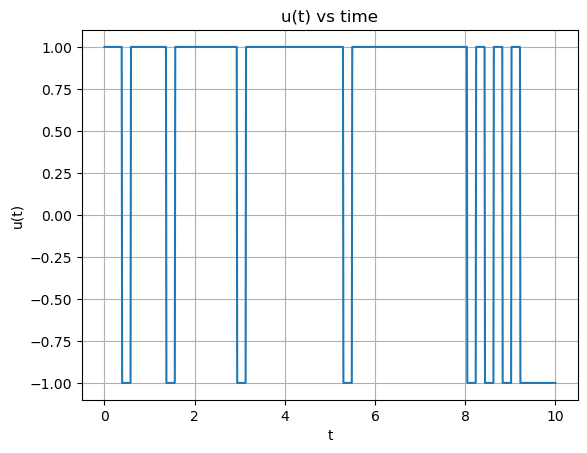

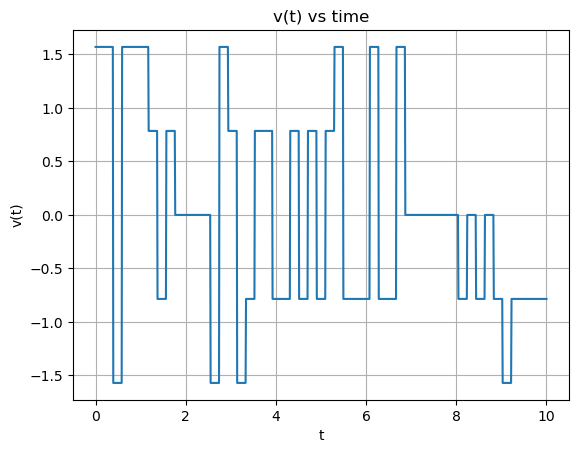

In [11]:
us=[action_set[i][0] for i in u_t]
vs=[action_set[i][1] for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


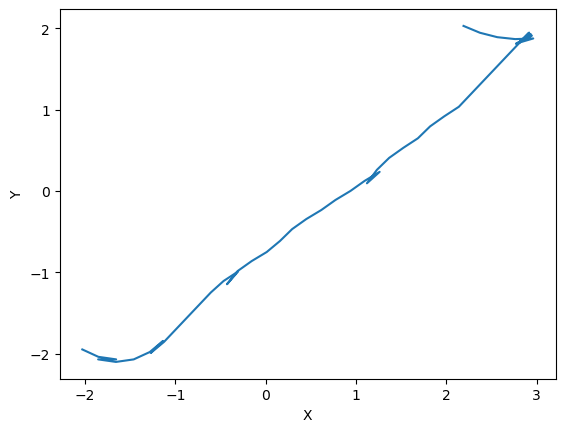

In [12]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

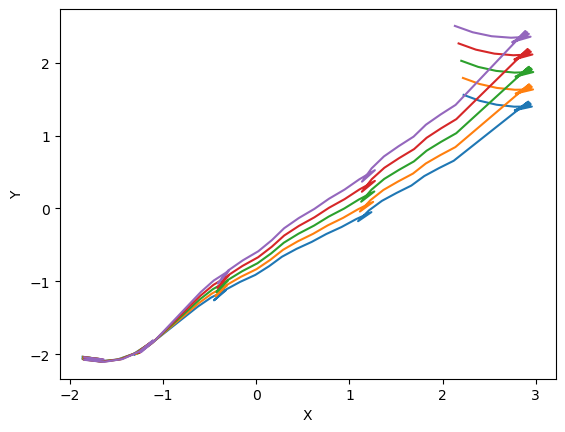

4.374798230112635


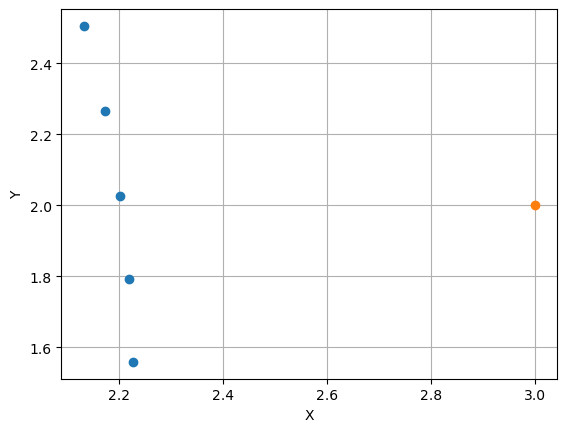

In [13]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

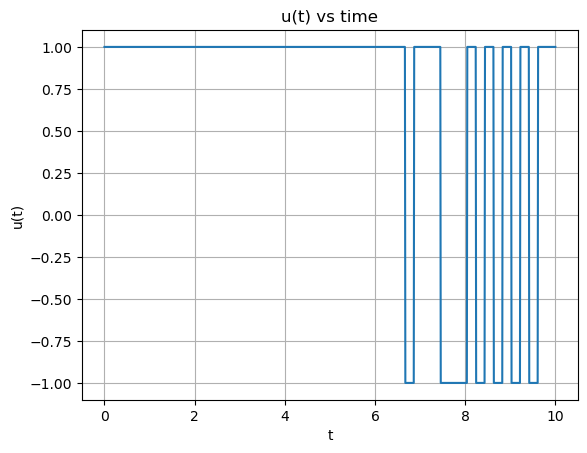

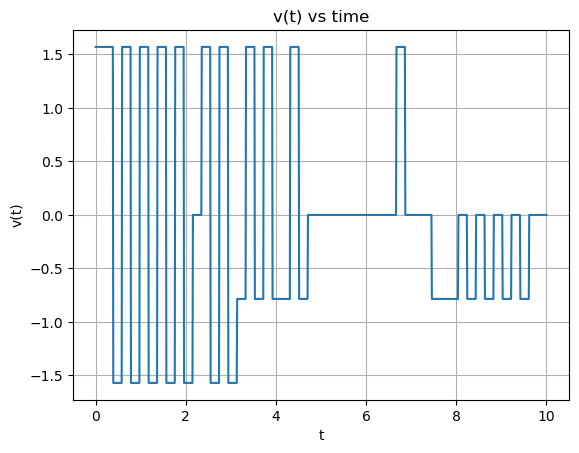

In [14]:
us=[action_set[i][0] for i in best_u]
vs=[action_set[i][1] for i in best_u]


u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

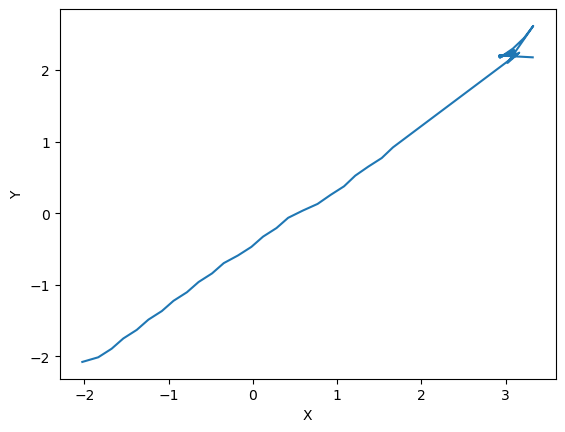

In [15]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

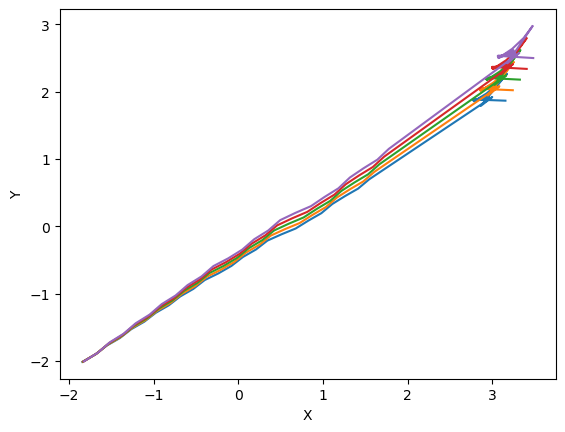

2.0375040282710972


In [16]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

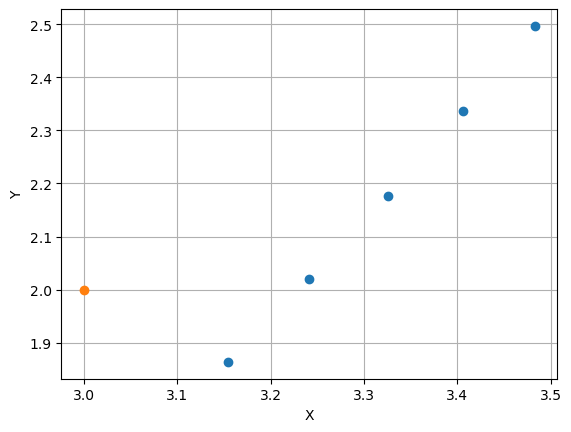

In [17]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

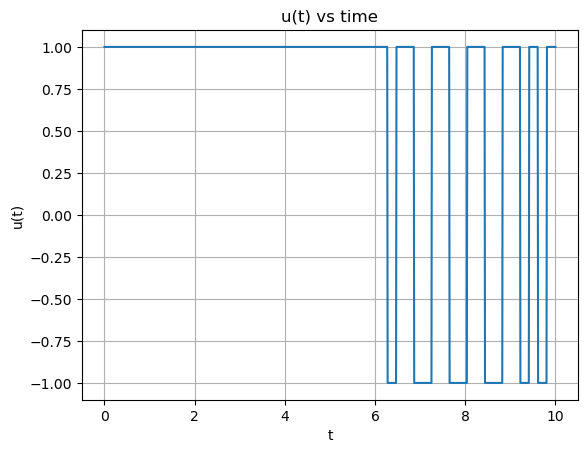

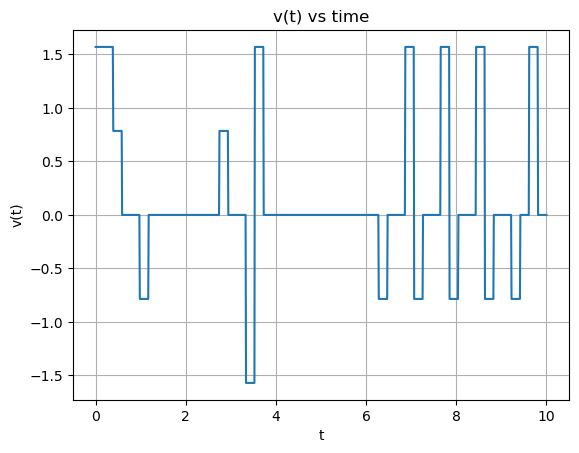

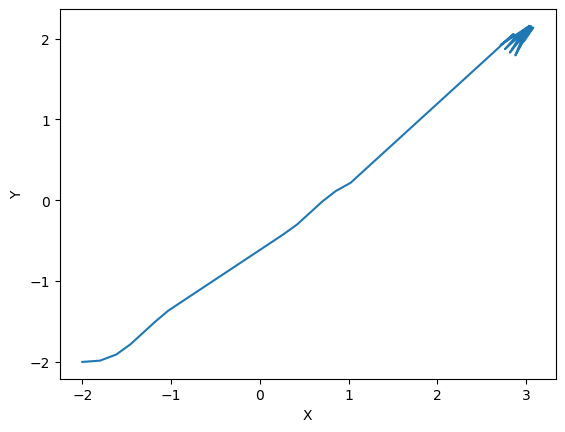

In [18]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[action_set[i][0] for i in u_t]
vs=[action_set[i][1] for i in u_t]


u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

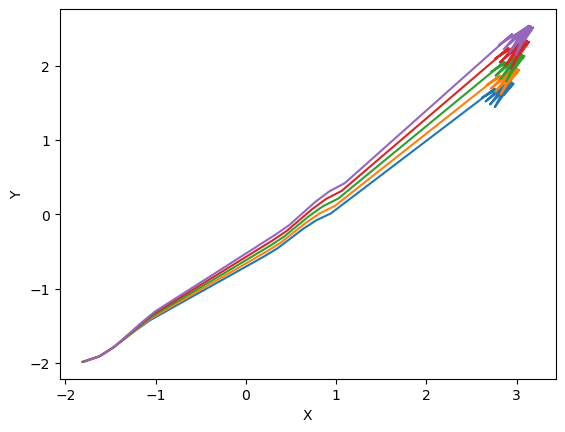

1.334179635175302


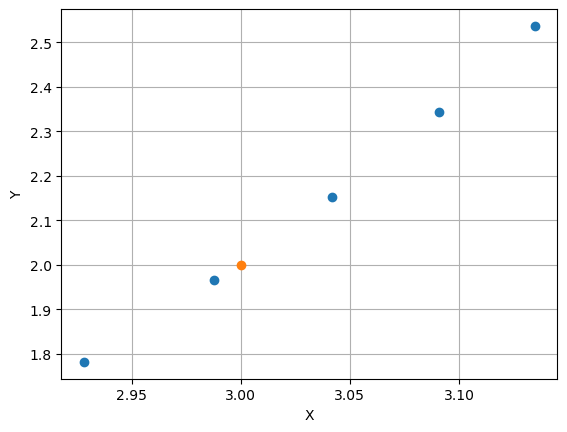

In [19]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()